In [29]:
!pip install jitcsde

In [30]:
!pip install git+https://github.com/aminakhshi/hints.git


  Cloning https://github.com/aminakhshi/hints.git to /tmp/pip-req-build-a8ccqdye
  Running command git clone --filter=blob:none --quiet https://github.com/aminakhshi/hints.git /tmp/pip-req-build-a8ccqdye
  Resolved https://github.com/aminakhshi/hints.git to commit 2f4d9a422f59baa24818e153739828c4ca6c1878
  Preparing metadata (setup.py) ... done


In [41]:
"""
Example case estimation of the Lorenz 96 model.

Created on 2024-03-10
Author: Amin Akhshi, amin.akhshi@gmail.com

References:
- [1] Akhshi, A., et al., 2024. HiNTS: Higher-Order Interactions in N-Dimensional Time Series.
- [2] Lorenz, E., 1998. Optimal sites for supplementary weather observations: Simulation with a small model. Journal of the Atmospheric Sciences.

See Also:
- [1] Tabar, M.R.R, et al., 2024. Revealing Higher-Order Interactions in High-Dimensional Complex Systems: A Data-Driven Approach. PRX.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from jitcsde import jitcsde, y, t

class L96SDE:
    """
    Simulates and visualizes the stochastic Lorenz 96 model, a simplified mathematical model for chaotic atmospheric behavior.

    Attributes:
        K (int): Number of variables in the model.
        F (float): Forcing constant.
        dt (float): Time step for the integration.
        sigma (float): Standard deviation of the noise.
        X (numpy.ndarray): Current state of the system.
        _history_X (list): History of system states.
        additive (bool): Indicates if the noise is additive.
        seed (int): Seed for RNG to ensure reproducibility.
        noprog (bool): If True, disables the progress bar.

    Parameters:
        K (int): Number of variables (default: 10).
        F (float): Forcing constant (default: 8).
        dt (float): Integration time step (default: 0.01).
        sigma (float): Noise standard deviation (default: 0.1).
        X_init (numpy.ndarray, optional): Initial state. Random if None (default: None).
        additive (bool): If True, noise is additive (default: True).
        seed (int): RNG seed for reproducibility (default: 0).
        show_plot (bool): If True, enables plotting (default: True).
        noprog (bool): If True, disables tqdm progress bar (default: False).
    """
    def __init__(self, K=10, F=8, dt=0.01, sigma=0.1, X_init=None, **kwargs):
        self.K = K
        self.F = F
        self.dt = dt
        self.sigma = sigma
        self.X0 = np.random.rand(K) if X_init is None else X_init.copy()
        self.X = [self.X0.copy()]
        self.additive = kwargs.get('additive', True)
        self.seed = kwargs.get('seed', 0)
        self.noprog = kwargs.get('noprog', False)
        self.show_plot  = kwargs.get('show_plot', True)

    def _define_f(self):
        """
        Defines the deterministic component of the Lorenz 96 model alongside its stochastic counterpart.

        The deterministic part is defined by a set of differential equations representing the model's dynamics,
        and the stochastic part introduces randomness to the system, simulating real-world unpredictability.

        Returns:
            list: A list of symbolic differential equations representing the Lorenz 96 model's dynamics.
        """
        f_sym = [
            (-y((j-1) % self.K) * (y((j-2) % self.K) - y((j+1) % self.K)) - y(j) + self.F)
            for j in range(self.K)
            ]
        return f_sym

    def _define_g(self):
        """
        Defines the stochastic component of the Lorenz 96 model.

        The stochastic component introduces randomness to the system, simulating real-world unpredictability.

        Returns:
            list: A list of symbolic equations representing the stochastic component of the Lorenz 96 model.
        """
        return [self.sigma for j in range(self.K)]
    def iterate(self, time):
        """
        Advances the model state over a specified period through numerical integration,
        recording the state at each step.

        This method uses the Just-In-Time Compilation Stochastic Differential Equation (JitCSDE) library
        to perform numerical integration, taking into account both the deterministic and stochastic
        components of the model.

        Parameters:
            time (float): The total time period over which to integrate the model, in model time units.
        """
        f_sym = self._define_f()
        g_sym = self._define_g()
        SDE = jitcsde(f_sym=f_sym, g_sym=g_sym, n=self.K, additive=self.additive)
        SDE.set_initial_value(initial_value=self.X0, time=0.0)
        SDE.set_seed(seed=self.seed)

        steps = int(time / self.dt)
        for _ in tqdm(range(steps), disable=self.noprog):
            self.X0 = SDE.integrate(SDE.t + self.dt)
            self.X.append(self.X0.copy())

    @property
    def _history(self):
        """
        This function help to provide access to the recorded history of the system states throughout the simulation.

        This property allows for analysis and visualization of the system's evolution over time.

        Returns:
            numpy.ndarray: A 2D array of the system's states over time, where each row represents a time step.
        """
        return np.array(self.X)

    def add_point(self, x):
        """
        Closes a loop in a plot by appending the first element of the input array to its end.

        This function is particularly useful for plotting cyclic structures, such as polar plots,
        ensuring a smooth and continuous appearance.

        Parameters:
            x (numpy.ndarray): The input array representing a series of points in a plot.

        Returns:
            numpy.ndarray: The modified array with the first element appended to the end.
        """
        return np.append(x, x[0])

    def static_plot(self):
        """
        Creates a static polar plot of the system's final state as recorded in the simulation history.

        This visualization method provides a snapshot of the system's state at the end of the simulation,
        offering insights into the system's dynamics and behavior.
        """
        x_theta = [2 * np.pi / self.K * i for i in range(self.K + 1)]
        fig, ax1 = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
        ax1.plot(x_theta, self.add_point(self._history[-1]), lw=3, zorder=10, label='X')
        self._configure_plot(ax1)

    def animate_plot(self, total_frames=200):
        """
        Generates an animation representing the system's evolution over time, automatically calculating
        the number of points to skip based on the desired total number of frames.

        Parameters:
            total_frames (int): The total number of frames for the animation.

        Returns:
            matplotlib.animation.FuncAnimation: The animation object, which can be displayed in a Jupyter
            notebook or saved to a file.
        """
        fig, ax1 = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
        linex1, = ax1.plot([], [], lw=3, zorder=10, label='X')
        self._configure_plot(ax1)

        x_theta = [2 * np.pi / self.K * i for i in range(self.K + 1)]

        # Calculate skip rate to fit the animation into the desired total number of frames
        history_length = len(self._history)
        skip = max(1, history_length // total_frames)

        def init():
            linex1.set_data([], [])
            return linex1,

        def animate(i):
            index = i * skip
            if index < history_length:  # Check to avoid index error
                x = self.add_point(self._history[index])
                linex1.set_data(x_theta, x)
            return linex1,

        ani = animation.FuncAnimation(fig, animate, frames=total_frames,
                                      interval=40, blit=True, init_func=init)
        plt.close()
        return ani

    def _configure_plot(self, ax):
        """
        Applies a common set of configurations to polar plots created by this class, enhancing
        the visual consistency across static and animated visualizations.

        Parameters:
            ax (matplotlib.axes.Axes): The matplotlib axes object to configure.
        """
        ax.set_rmin(-14); ax.set_rmax(14)
        l = ax.set_rgrids([-7, 0, 7], labels=['', '', ''])[0][1]
        l.set_linewidth(2)
        ax.set_thetagrids([])
        ax.set_rorigin(-22)
        ax.legend(frameon=False, loc=1)
        plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)


model = L96SDE()
model.iterate(10000.0)


  0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


  1%|          | 837/100000 [00:02<03:40, 450.19it/s]

Using default integration parameters.


100%|██████████| 100000/100000 [00:10<00:00, 9106.03it/s]


In [35]:
import numpy as np
import pandas as pd
import warnings
from skimage.util.shape import view_as_blocks
from itertools import combinations_with_replacement

class kmcc:
    """
    The Kramers-Moyal Coefficients (KMC) Calculator class for analyzing time series data.

    This class analyzes N-dimensional time series data to estimate the interactions in deterministic and stochastic parts
    of a given N-dimensional time series and reconstructs a stochastic differential equation (SDE) within the Kramers-Moyal
    framework. The SDE represents and approximates the dynamics of the underlying system.

    References
    ----------
    Please cite the following paper when using this code:

    - Akhshi, A., et al., 2024. HiNTS: Higher-Order Interactions in N-Dimensional Time Series. arXive.
    - Tabar, M.R.R, et al., 2024. Revealing Higher-Order Interactions in High-Dimensional Complex Systems: A Data-Driven Approach. PRX.
    - Nikakhtar, F., et al. 2023. Data-driven reconstruction of stochastic dynamical equations based on statistical moments. New Journal of Physics.
    """

    def __init__(self, filepath=None, ts_array=None, **kwargs):
        """
        Initialize the KMC Calculator with provided parameters.

        Args
        ----------
        filepath (str):
            Path to the file containing the time series data.
        ts_array (numpy.ndarray):
            Time series data as a 2D numpy array.
        dt (float):
            Time interval between data points.
        interaction_order (int or list or tuple):
            Order of the polynomial to be calculated. If a tuple is provided, the first and second elements represent the lower and upper bounds of the order, respectively.
        estimation_mode (str):
            Mode of calculation ('drift' or 'diffusion').
        window_exp_order (int):
            Exponential order for window size calculation.

        Notes
        ----------
        ## TODO: the choice of options between the filepath and ts_array should be automatically handled by the class.

        * If filepath is provided the priority is given to the filepath and the ts_array is ignored. It's recommended to provide either filepath or ts_array.

        * The KMC Calculator requires a time series of N-dimensional data, where N is the number of state variables.

        * If the time series data is zero-mean for the estimation of the drift coefficients, exclude 0 from the order list.

        * To determine the upper limit of the interaction order, refer to Appendix J: "Estimating the Highest Order Z of Expansion from Data.

        Hints
        ----------
        For time series data exhibiting second-order stationarity, the typical number of data points required to estimate interaction strengths up to order Z = 3 is ~10^4 - 10^6 data points. For smaller datasets, it is advisable to choose a lower order of expansion, such as Z = 2 or Z = 1.
        """
        self.filepath = filepath
        self.time_series = ts_array if filepath is None else self._load_data(filepath)
        self.dt = kwargs.get('dt', 1)
        self.order = kwargs.get('interaction_order', [0, 1])
        self.mode = kwargs.get('estimation_mode', 'drift')
        self.window_order = kwargs.get('window_exp_order', 6)
        self._check_inputs()
        self._prepare_data()

    def _load_data(self):
        """
        Loads data from a file into a numpy array. Supports CSV, TXT, NPY, and pickle formats.

        Returns
        ----------
        timeseries (numpy.ndarray): The loaded timeseries from the file as a numpy array
        """
        if not isinstance(self.filepath, str):
            raise ValueError("The filepath must be a string.")

        # Determine the file format
        if self.filepath.endswith('.csv') or self.filepath.endswith('.txt'):
            self.time_series = pd.read_csv(self.filepath).values
        elif self.filepath.endswith('.npy'):
            self.time_series = np.load(self.filepath)
        elif self.filepath.endswith('.pkl') or self.filepath.endswith('.pickle'):
            with open(self.filepath, 'rb') as f:
                self.time_series = pickle.load(f)
            # Ensure the loaded data is a numpy array
            if not isinstance( self.time_series, np.ndarray):
                self.time_series = np.array(self.time_series)
        else:
            raise ValueError("Unsupported file format. Please use CSV, TXT, NPY, or pickle.")

        return self.time_series
    def _check_inputs(self):
        """
        Validates essential inputs for the KMC Calculator.

        Raises
        ----------
        AssertionError: If input data or parameters are invalid.
        """
        assert len(self.time_series.shape) == 2, 'Time series must have (n_samples, dimensions) shape'
        assert self.time_series.shape[0] > 0, 'No data in time series'
        assert (np.array(self.order) >= 0).all(), 'Negative order is not permitted'
        assert self.mode in ['drift', 'diffusion'], f'Mode "{self.mode}" is not valid. Choose "drift" or "diffusion".'

    def _prepare_data(self):
        """
        Preprocesses input data for model calculations.

        Calculates differences (increments) between consecutive time points, extracts the
        underlying values, and generates all possible index combinations based on the
        specified interaction order.
        """
        self.differences = np.diff(self.time_series, axis=0)
        self.values = self.time_series[:-1, :]
        self.n_samples, self.dimensions = self.values.shape
        self.index_combinations = self._generate_index_combinations()

    def _generate_index_combinations(self):
        """
        Creates combinations of indices representing interactions between variables.

        Returns
        ----------
        list: A list of index combinations, where each combination is a tuple.
        """
        if isinstance(self.order, int):
            comb_lengths = np.arange(self.order + 1)
        elif isinstance(self.order, tuple) and len(self.order) == 2:
            comb_lengths = np.arange(self.order[0], self.order[1] + 1)
        else:
            comb_lengths = np.sort(np.array(self.order))

        return [comb for length in comb_lengths for comb in
                combinations_with_replacement(range(self.dimensions), length)]

    def _segment_data(self):
        """
        Divides the data into segments for windowed analysis.

        Returns
        ----------
        tuple:
            * Segmented values as a NumPy array.
            * Remaining values not included in segmentation.
            * Segmented differences as a NumPy array.
            * Remaining differences not included in segmentation.
        """
        window_size = 10 ** self.window_order - 1
        num_windows = self.n_samples // window_size
        remainder = self.n_samples % window_size

        segmented_values = view_as_blocks(self.values[:num_windows * window_size], (window_size, self.dimensions))
        segmented_diffs = view_as_blocks(self.differences[:num_windows * window_size], (window_size, self.dimensions))

        segmented_values = np.squeeze(segmented_values, axis=1)
        segmented_diffs = np.squeeze(segmented_diffs, axis=1)

        return segmented_values, self.values[-remainder:], segmented_diffs, self.differences[-remainder:]

    def _compute_ts_matrix(self, segment):
        """
        Computes the time series matrix for a given data segment.

        Args
        ----------
        segment (numpy.ndarray):
            A segment of the time series data.

        Returns
        ----------
        numpy.ndarray: The calculated time series matrix.
        """
        return np.array([np.prod(segment[:, comb], axis=1) for comb in self.index_combinations]).T

    def _compute_M_matrix(self, ts_matrix):
        """
        Computes the M matrix (statistical moment matrix) to solve the set of linear equations to obtain the interaction strengths.

        Args
        ----------
        ts_matrix (numpy.ndarray):
            The time series matrix.

        Returns
        ----------
        numpy.ndarray:
            The calculated M matrix.

        Notes
        ----------
        * For reliable estimation of interaction coefficients, ensure the tails of the joint probability distribution functions (PDFs) are sufficiently resolved. This can be assessed by plotting products like x_i^m * p(x_i) for relevant powers 'm' and examining their convergence (refer to Fig. 4 in the appendix of Tabar et al. (2024)[1]).

        * Statistical moments may require longer integration times (T) for proper convergence. Monitor the stability of moments like <x_i^(2k)> as T increases (refer to Fig. 5 in Tabar et al. (2024)[1]).

        * Errors in moment calculations typically decrease as 1/(N*dt)^gamma with gamma ~ 0.5 (refer to Fig. 6 in Tabar et al. (2024)[1]).

        See Also
        ----------
        * Appendix J of the Tabar et al. (2024)[1], PRX for in-depth discussions and guidelines.

        .. [1] Tabar, M.R.R, et al., 2024. Revealing Higher-Order Interactions in High-Dimensional Complex Systems: A Data-Driven Approach. PRX.
        """
        return ts_matrix.T @ ts_matrix

    def _compute_Y_matrix(self, ts_matrix, segment_diff):
        """
        Constructs the Y matrix, representing statistical increments matrix from empirical N-dimensional timeseries

        Args
        ----------
        ts_matrix (numpy.ndarray):
            The time series matrix.
        segment_diff (numpy.ndarray):
            Differences within the data segment.

        Returns
        ----------
        numpy.ndarray:
            The calculated Y matrix.

        Notes
        ----------
        * Considerations outlined for the M matrix calculation in Appendix J also apply to the Y matrix computations.
        """

        if self.mode == 'drift':
            return ts_matrix.T @ segment_diff

        if self.mode == 'diffusion':
            diffusion_indices = list(combinations_with_replacement(range(self.dimensions), 2))
            product_diff = np.array([np.prod(segment_diff[:, idx,], axis=1) for idx in diffusion_indices]).T
            return ts_matrix.T @ product_diff

    def _construct_keys(self):
        """
        Generates descriptive keys for representing coefficients.

        Returns
        ----------
        list: A list of strings representing interaction terms (e.g., 'x1', 'x2x3').
        """
        var_keys = [f'x{i + 1}' for i in range(self.dimensions)]
        return [''.join(var_keys[i] for i in comb) or '1' for comb in self.index_combinations]

    def get_coefficients(self):
        """
        Calculates the coefficients of the Langevin equation from the input time series data.
        This involves computing the M and Y matrices and solving the linear system to estimate
        the coefficients for both the deterministic and stochastic parts of the equation.

        Returns
        ----------
        coefficients (pandas.DataFrame):
            A DataFrame containing the estimated coefficients for each term in the polynomial expansion of the interactions. The coefficients are indexed by the corresponding
            terms, representing the interactions between the state variables.

        Notes
        ----------
        If the time series data has a zero mean, exclude 0 from the list of orders. Conversely, to estimate \(\alpha\), set the order to 0 if the data does not have a zero mean.
        """

        M_matrix = np.zeros((len(self.index_combinations), len(self.index_combinations)))
        Y_matrix_dim = len(list(combinations_with_replacement(range(self.dimensions), 2))
                           ) if self.mode == 'diffusion' else self.dimensions
        Y_matrix = np.zeros((len(self.index_combinations), Y_matrix_dim))

        segmented_values, values_remainder, segmented_diffs, diffs_remainder = self._segment_data()

        for values, diffs in zip(segmented_values, segmented_diffs):
            ts_matrix = self._compute_ts_matrix(values)
            M_matrix += self._compute_M_matrix(ts_matrix)
            Y_matrix += self._compute_Y_matrix(ts_matrix, diffs)

        if len(values_remainder) > 0:
            ts_matrix = self._compute_ts_matrix(values_remainder)
            M_matrix += self._compute_M_matrix(ts_matrix)
            Y_matrix += self._compute_Y_matrix(ts_matrix, diffs_remainder)

        M_matrix /= self.n_samples
        Y_matrix /= self.n_samples
        coefficients = np.linalg.solve(M_matrix, Y_matrix) / self.dt
        coefficients = pd.DataFrame(coefficients, index=self._construct_keys())
        if self.mode == 'diffusion':
            coefficients.columns = np.array([''.join([str(comb[0]), str(comb[1])]) for comb in list(combinations_with_replacement(range(self.dimensions), 2))])
        return coefficients

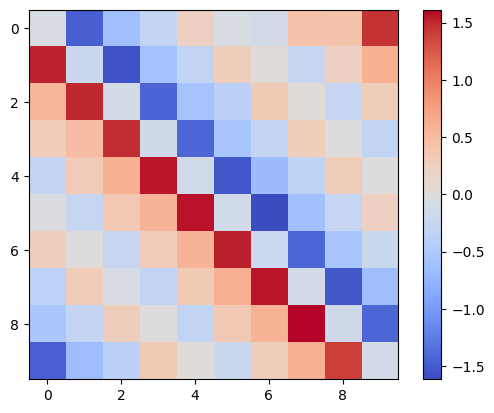

In [42]:
calulator = kmcc(ts_array=model._history, dt=model.dt, interaction_order=[0,1],
                       estimation_mode='drift')
coeffs = calulator.get_coefficients()
plt.figure()
plt.colorbar((plt.imshow(coeffs.values[1:11,:], cmap='coolwarm')))
plt.title("Coefficient Matrix")
plt.show()

In [39]:
x1 = coeffs.copy()

In [52]:
x1 = np.array(x1)
x2 = np.array(coeffs)

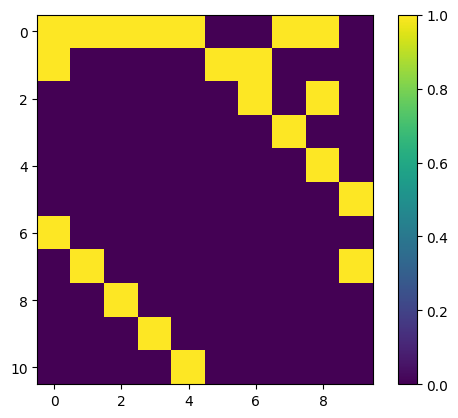

In [62]:
plt.colorbar(plt.imshow(np.abs(x1-x2)/(np.abs(x1)+np.abs(x2))>0.2))
plt.title("Difference Between Variance 0.1 and 0.5 Bigger Than 0.2")
plt.show()